## Analiza czasowo-częstotliwościowa sygnału

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fs = 1600 # częstotliwość próbkowania [Hz]
lsb_to_g = 0.0039 # przelicznik LSB -> g (FULL_RES = 3.9 mg/LSB)

df = pd.read_csv('data/pomiar_bez_20.csv')

df['X_g'] = df['X'] * lsb_to_g
df['Y_g'] = df['Y'] * lsb_to_g
df['Z_g'] = df['Z'] * lsb_to_g

df['R_g'] = np.sqrt(df['X_g']**2 + df['Y_g']**2 + df['Z_g']**2)

t = df['czas [s]'].to_numpy()


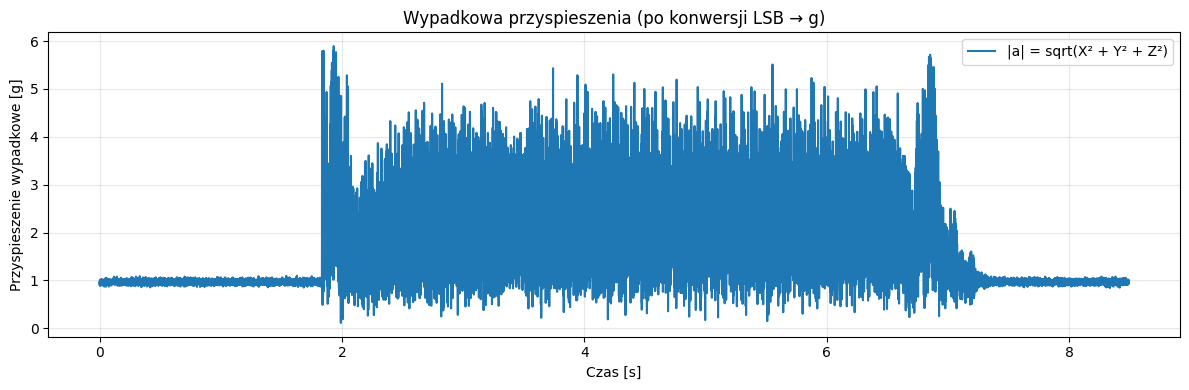

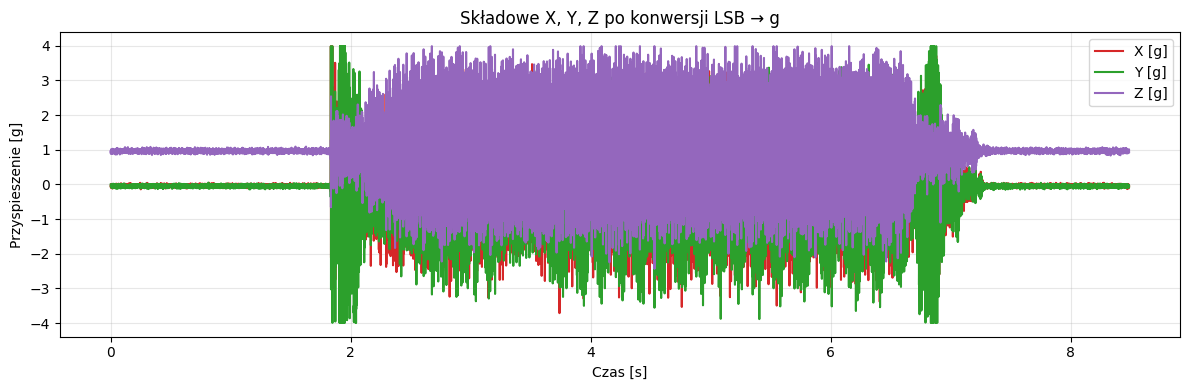

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(t, df['R_g'], label='|a| = sqrt(X² + Y² + Z²)', color='#1f77b4')
plt.xlabel('Czas [s]')
plt.ylabel('Przyspieszenie wypadkowe [g]')
plt.title('Wypadkowa przyspieszenia (po konwersji LSB → g)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(t, df['X_g'], label='X [g]', color='#d62728')
plt.plot(t, df['Y_g'], label='Y [g]', color='#2ca02c')
plt.plot(t, df['Z_g'], label='Z [g]', color='#9467bd')
plt.xlabel('Czas [s]')
plt.ylabel('Przyspieszenie [g]')
plt.title('Składowe X, Y, Z po konwersji LSB → g')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


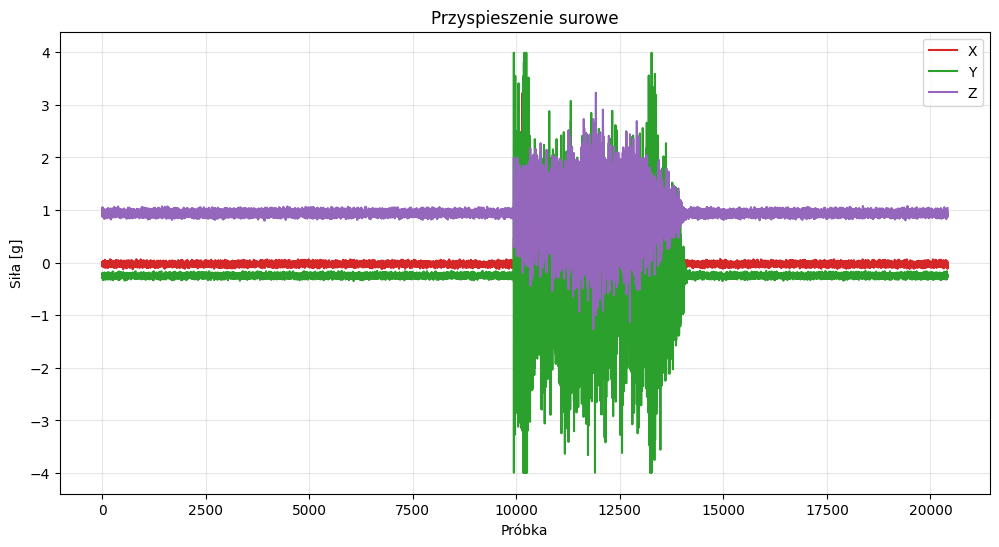

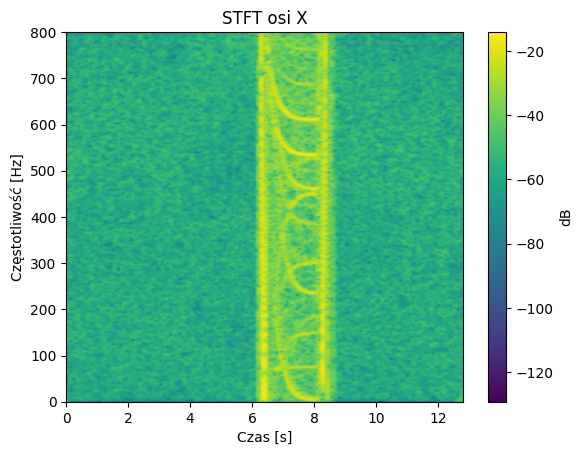

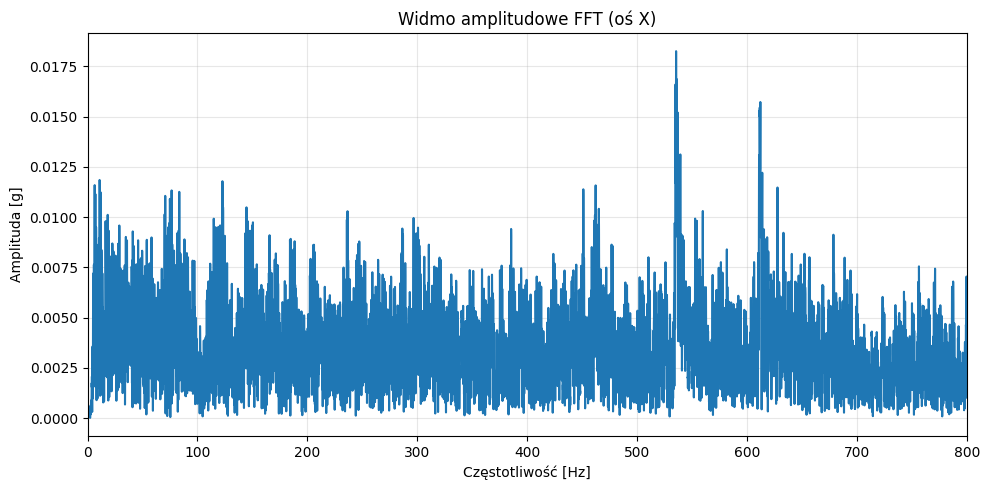

In [24]:
from scipy import signal

A = df[['X','Y','Z']].values.astype(np.float64) * lsb_to_g 

plt.figure(figsize=(12, 6))
plt.plot(A[:,0], label='X', color='#d62728')
plt.plot(A[:,1], label='Y', color='#2ca02c')
plt.plot(A[:,2], label='Z', color='#9467bd')
plt.xlabel('Próbka'); plt.ylabel('Siła [g]'); plt.title('Przyspieszenie surowe')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

N0 = int(2 * fs)
bias = A[:int(2*fs)].mean(axis=0)
A0 = A - bias

#usunięcie grawitacji: high-pass fc=5 Hz
fc = 5.0
b, a = signal.butter(2, 5/(fs/2), btype='highpass')
A_hp = signal.filtfilt(b, a, A0, axis=0)

# Analza czasowo-częstotliwościowa
f, t, Sxx = signal.stft(A_hp[:,0], fs=fs, window='hann', nperseg=512, noverlap=384)
plt.pcolormesh(t, f, 20*np.log10(np.abs(Sxx)), shading='gouraud')
plt.ylim(0, 800)
plt.xlabel('Czas [s]')
plt.ylabel('Częstotliwość [Hz]')
plt.title('STFT osi X')
plt.colorbar(label='dB')
plt.show()

x = A_hp[:, 0]    # oś X po usunięciu biasu i grawitacji

# Parametry
N = len(x)
T = 1 / fs
Xf = np.fft.fft(x)
freqs = np.fft.fftfreq(N, T)

pos_mask = freqs >= 0
freqs = freqs[pos_mask]
amp = 2.0 / N * np.abs(Xf[pos_mask])   # amplituda znormalizowana

# fourier
plt.figure(figsize=(10,5))
plt.plot(freqs, amp, color='#1f77b4')
plt.xlim(0, 800) # ogranicz do interesującego pasma
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda [g]')
plt.title('Widmo amplitudowe FFT (oś X)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()